# Visualization API Example

This notebook shows how how to use the `visualization` library for viewing images stored on disk.

In [20]:
import collections
import sys
if '../' not in sys.path:
    sys.path.append("../")

import folium
import folium.plugins
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython.core.display import display, HTML
    
import storage

%matplotlib inline

In [21]:
# Open an on-disk image dataset.
dataset = storage.DiskDataset("/tmp/ipis")

In [22]:
# pd.DataFrame listing all (location_id, image_source_id, metadata).
dataset.metadata().sort_values(["location_id", "source_id"]).sample(5)

,location_id,metadata,source_id
190,codmine00081,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
243,codmine01902,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
1,codmine00001,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
161,codmine00458,"{u'projection': u'WGS 84', u'bottom_right': [2...",mask
335,codmine00467,"{u'dates': [u'20161015', u'20161116', u'201612...",landsat8


In [23]:
# Loads image from disk.
location_id = "codmine00126"
image = dataset.load_image(location_id, "landsat8")
mask = dataset.load_image(location_id, "mask")
meta = dataset.image_metadata(location_id, "landsat8")["metadata"]
date = 2


longitude, latitude = meta["center"]
print("longitude = %f | latitude = %f" % (longitude, latitude))
display(HTML('<a href="https://www.google.com/maps/place/%f,%f">Google Maps</a>' % (latitude, longitude)))

longitude = 30.035037 | latitude = 2.021614


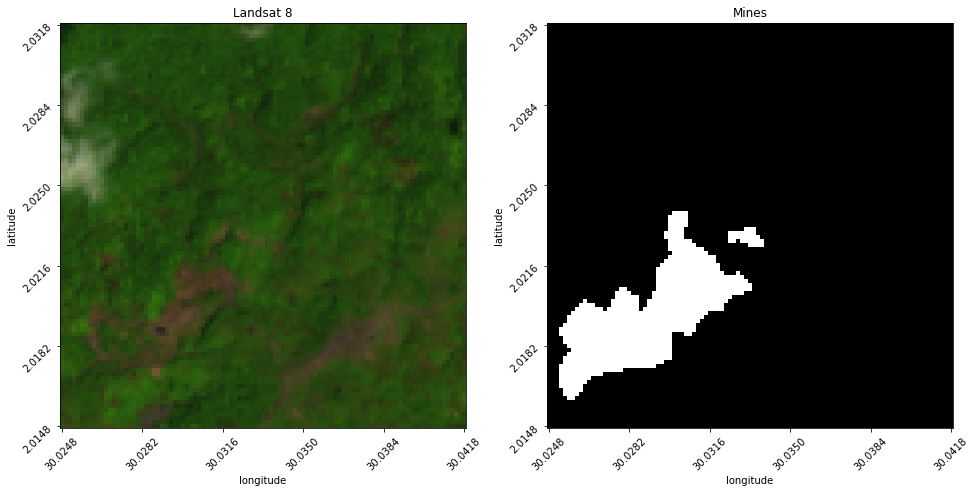

In [24]:
# Visualize image

_BoundingBox = collections.namedtuple(
    'BoundingBox', 
    ['min_longitude', 'min_latitude', 'max_longitude', 'max_latitude'])

class BoundingBox(_BoundingBox):
    
    @classmethod
    def from_metadata(cls, metadata):
        for key in ["top_left", "bottom_right"]:
            assert key in metadata, "%s isn't in metadata. Unable to infer image bounding box." % (key,)
        
        min_lat=meta["bottom_right"][1]
        max_lat=meta["top_left"][1]
        min_lon=meta["top_left"][0]
        max_lon=meta["bottom_right"][0]
        assert min_lat < max_lat, 'min_lat = %s should be less than max_lat = %s' % (min_lat, max_lat)
        assert min_lon < max_lon, 'min_lon = %s should be less than max_lon = %s' % (min_lon, max_lon)
        
        return cls(min_longitude=min_lon, max_longitude=max_lon,
                   min_latitude=min_lat, max_latitude=max_lat)

def show_image(image, bounding_box=None, title=None):
    """Shows a single satellite image.
    
    Args:
        image: np.array of rank 2 or 3. Image to be shown.
        bounding_box: None or BoundingBox instance. Indicates latitude, longitude of image.
        title: None or str. Title of axis.
    """
    # Normalize colors based on smallest, largest values in image.
    norm = colors.Normalize(vmin=np.min(image), vmax=np.max(image))
    plt.imshow(image, cmap="gray", norm=norm)
    
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    
    if bounding_box:
        keys, _ = plt.xticks()
        values = np.linspace(bounding_box.min_longitude, bounding_box.max_longitude, num=len(keys), endpoint=False)
        values = ["{:0.4f}".format(value) for value in values]
        plt.xticks(keys[1:-1], values[1:-1], rotation=45)

        keys, _ = plt.yticks()
        values = np.linspace(bounding_box.max_latitude, bounding_box.min_latitude, num=len(keys), endpoint=False)
        values = ["{:0.4f}".format(value) for value in values]
        plt.yticks(keys[1:-1], values[1:-1], rotation=45)
    
    if title:
        plt.title(title)


fig, axs = plt.subplots(1, 2, figsize=(16, 16))

plt.sca(axs[0])
show_image(image[:, :, [5, 4, 3], date], BoundingBox.from_metadata(meta), title="Landsat 8")

plt.sca(axs[1])
show_image(mask, BoundingBox.from_metadata(meta), title="Mines")

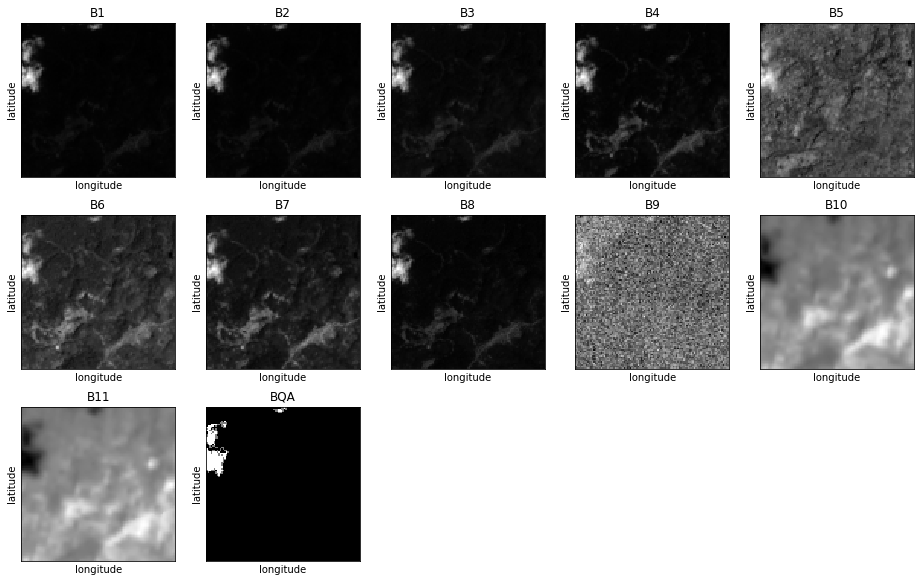

In [25]:
# Visualize color bands.
        
def show_color_bands(image, axs=None, ncols=None, titles=None):
    """Shows each of an image's color bands.
    
    Args:
        image: np.array of rank 3. Dimensions represent (longitude, latitude, color band).
        axs: None or np.array of of rank 2. Contains matplotlib axes for each color band.
        ncols: None or int. Number of columns per row. If None, defaults to 6.
        titles: None or list of strings. Title for each axes.
    """
    num_bands = image.shape[-1]
    assert num_bands == len(titles)
    
    ncols = ncols or 6
    titles = titles or [None for _ in range(num_bands)]
    
    if axs is None:
        nrows = int(np.ceil(num_bands / float(ncols)))
        fig = plt.gcf()
        axs = np.asarray([fig.add_subplot(nrows, ncols, i+1) 
                          if i < num_bands else None
                          for i in range(nrows * ncols)])
        axs = np.reshape(axs, [nrows, ncols])
    else:
        nrows, ncols = axs.shape
    assert nrows * ncols >= num_bands
    
    axs = axs.flatten()
    for i in range(num_bands):
        plt.sca(axs[i])
        show_image(image[..., i], title=titles[i])
        plt.xticks([])
        plt.yticks([])
    
plt.figure(figsize=(16, 10))
show_color_bands(image[..., date], ncols=5, titles=meta['bands'])

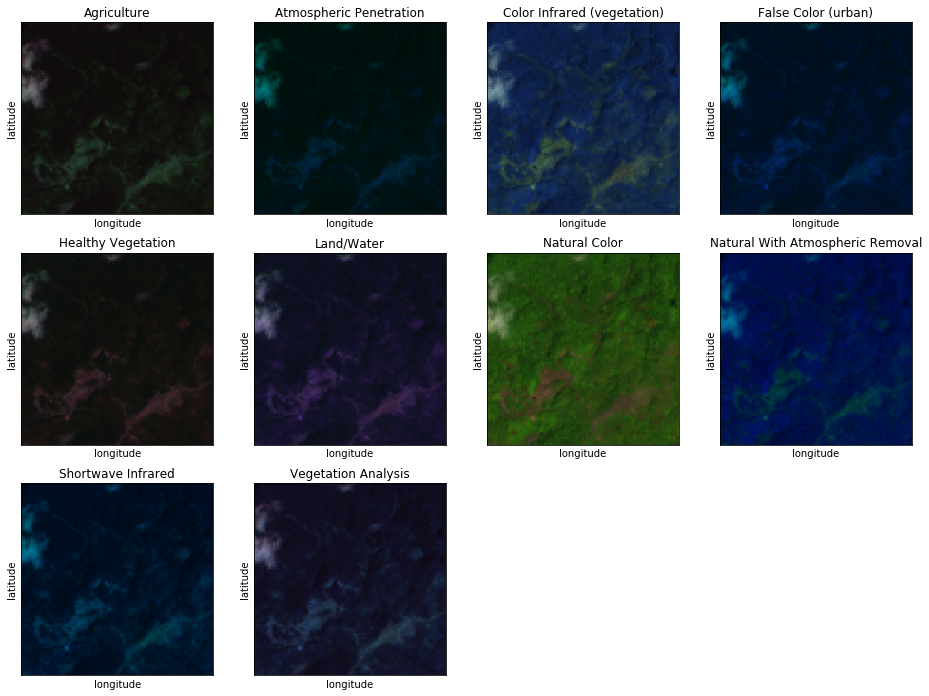

In [26]:
def show_landsat8_band_combinations(image, axs=None, ncols=None):
    """Shows common color band combinations for Landsat 8 images.
    
    Args:
      image: np.array of rank 3. Represents longitude, latitude, and color band. Last dimension show be ordered B1...B11.
      axs: None or np.array of rank 2. Contains matplotlib Axes to plot each color combination on.
      ncols: None or int. Number of columns per row if creating axes from scratch.
    """
    
    # Based on https://blogs.esri.com/esri/arcgis/2013/07/24/band-combinations-for-landsat-8/
    LANDAT8_BAND_COMBOS = {
        'Natural Color': [5, 4, 3],
        'False Color (urban)': [8, 7, 5],
        'Color Infrared (vegetation)': [6, 5, 4],
        'Agriculture': [7, 6, 3],
        'Atmospheric Penetration': [8, 7, 6],
        'Healthy Vegetation': [6, 7, 3],
        'Land/Water': [6, 7, 5],
        'Natural With Atmospheric Removal': [8, 6, 4],
        'Shortwave Infrared': [8, 6, 5],
        'Vegetation Analysis': [7, 6, 5],
    }
    titles, band_combos = zip(*sorted(LANDAT8_BAND_COMBOS.items()))
    images = [image[:, :, band_combo] for band_combo in band_combos]
    images = np.stack(images, axis=-1)
    show_color_bands(images, axs=axs, ncols=ncols, titles=titles)
    
plt.figure(figsize=(16, 12))
show_landsat8_band_combinations(image[..., date], ncols=4)

In [33]:
# Build map. Overlay image on top.

MAPBOX_API_KEY = 'pk.eyJ1IjoiZHVja3dvcnRoZCIsImEiOiJjamE0YmdtcDQ5dTB1MndsZ3N5eDk4a2tiIn0.R_cSc4qJEPLxnlWnFqx-lg'

def create_folium_map(meta, tiles=None):
    """Create a folium.Map over meta's location."""
    
    if tiles == 'Mapbox':
        map_kwargs = {
            'attr': 'Mapbox Satellite',
            'tiles': 'http://{s}.tiles.mapbox.com/v4/mapbox.satellite/{z}/{x}/{y}.png?access_token=' + MAPBOX_API_KEY,
        }
    elif tiles == 'ArcGIS':
        map_kwargs = {
            'attr': 'Tile: Esri - Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community',
            'tiles':'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        }
    else:
        map_kwargs = {
            'tiles': tiles
        }
    
    folium_map = folium.Map(**map_kwargs)
    

    min_lat=meta["top_left"][1]
    max_lat=meta["bottom_right"][1]
    min_lon=meta["top_left"][0]
    max_lon=meta["bottom_right"][0]

    folium_map.add_child(folium.LatLngPopup())
    folium_map.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
    
    return folium_map


def overlay_image_on_map(folium_map, image, bounding_box, opacity=None):
    """Overlay an image onto a folium.Map."""
    overlay = folium.plugins.ImageOverlay(
        image=image,
        bounds=[(bounding_box.min_latitude, bounding_box.min_longitude), 
                (bounding_box.max_latitude, bounding_box.max_longitude)],
        opacity=opacity or 0.5,
    )
    overlay.add_to(folium_map)
    return folium_map

folium_map = create_folium_map(meta, tiles='ArcGIS')
overlay_image_on_map(
    folium_map, 
    image[:, :, [5, 4, 3], date], 
    BoundingBox.from_metadata(meta), 
    opacity=0.75)
overlay_image_on_map(
    folium_map, 
    mask, 
    BoundingBox.from_metadata(meta), 
    opacity=0.2)

folium_map